---
Some useful $\LaTeX$ commands are defined in this cell:
$$
\newcommand{\abs}[1]{\left\lvert#1\right\rvert}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\set}[1]{\left\{#1\right\}}
\newcommand{\paren}[1]{\left(#1\right)}
\newcommand{\brack}[1]{\left[#1\right]}
\newcommand{\ip}[2]{\left\langle#1,#2\right\rangle}
\DeclareMathOperator{\span}{span}
\DeclareMathOperator{\fl}{fl}
\abs{x}, \norm{x}, \set{x}, \paren{x}, \brack{x}, \ip{x}{y}, \span, \fl
$$

---

---
# 15.3 Gaussian quadrature
---

The composite quadrature rules in the previous section all used points that were **equally spaced**. Such rules are called **Newton-Cotes formulas**.

In this section, we consider numerical methods for integration that use any choice of points $\set{x_0,\ldots,x_n}$.

We will see that by choosing the points $x_0,\ldots,x_n$ wisely, we will be able to obtain higher precision methods.

The goal is to have a formula that is **exact** for higher degree polynomials.

---

## Example

Consider approximating the area under the graph of $f(x) = \cos\paren{\frac{\pi}{2} x}$ over the interval $[-1, 1]$:

$$\int_{-1}^1 \cos\paren{\frac{\pi}{2} x} dx = \frac{4}{\pi} = \underline{1.2732395447351628} \ldots .$$

The **Simpson rule** gives us:

$$\int_{-1}^1 \cos\paren{\frac{\pi}{2} x} dx \approx \frac{2}{6}\paren{0 + 4 \cdot 1 + 0} = \underline{1.3}333333333333333 \ldots .$$

Recall that the Simpson rule is obtained by integrating the quadratic that interpolates the points $(-1, 0)$, $(0, 1)$, and $(1, 0)$:

$$p_2(x) = 1 - x^2.$$

If $q_2$ is the quadratic polynomial that interpolates 

$$\paren{-\sqrt{\frac35},\, f\paren{-\sqrt{\frac35}}}, \quad (0,\,f(0)), \quad \paren{\sqrt{\frac35},\, f\paren{\sqrt{\frac35}}},$$

then we have a more accurate approximation:

$$\int_{-1}^1 q_2(x)\,dx = \underline{1.27}41237545999626  \ldots.$$

In [1]:
using SymPy

f(x) = cos(PI/2*x)
a, b = -sqrt(Sym(3//5)), sqrt(Sym(3//5))

t = symbols("t")

L0 = (t - (a+b)/2)*(t - b)/(a - (a+b)/2)/(a - b)
L1 = (t - a)*(t - b)/((a+b)/2 - a)/((a+b)/2 - b)
L2 = (t - a)*(t - (a+b)/2)/(b - a)/(b - (a+b)/2)

q = expand(f(a)*L0 + f((a+b)/2)*L1 + f(b)*L2)

            2    ⎛√15⋅π⎞    
     2   5⋅t ⋅cos⎜─────⎟    
  5⋅t            ⎝  10 ⎠    
- ──── + ─────────────── + 1
   3            3           

In [2]:
Float64(integrate(q, (t, -1, 1)))

1.2741237545999626

In [3]:
f(x) = cos(pi/2*x)
a, b = -sqrt(3/5), sqrt(3/5)

p2(x) = 1 - x.^2

q2(x) = 
    f(a)*(x - (a+b)/2).*(x - b)/(a - (a+b)/2)/(a - b) + 
    f((a+b)/2)*(x - a).*(x - b)/((a+b)/2 - a)/((a+b)/2 - b) +
    f(b)*(x - a).*(x - (a+b)/2)/(b - a)/(b - (a+b)/2)

q2 (generic function with 1 method)

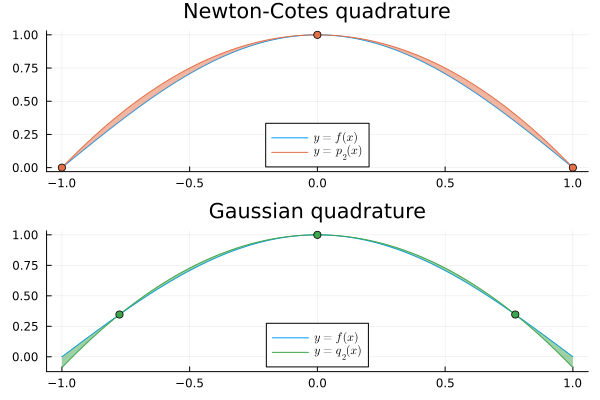

In [4]:
using Plots, LaTeXStrings

xx = range(-1, 1, length=100)

plot(layout=(2,1), legend=:bottom)
plot!(subplot=1, title="Newton-Cotes quadrature")
plot!(xx, f.(xx), c=1, label=L"y = f(x)")
plot!(xx, p2.(xx), c=2, ribbon=(p2.(xx)-f.(xx), zeros(length(xx))), 
    label=L"y = p_2(x)")
scatter!([-1, 0, 1], [f(-1), f(0), f(1)], c=2, label=:none)

plot!(subplot=2, title="Gaussian quadrature")
plot!(xx, f.(xx), c=1, label=L"y = f(x)", subplot=2)
plot!(xx, q2.(xx), c=3, ribbon=(q2.(xx)-f.(xx), zeros(length(xx))),
    label=L"y = q_2(x)", subplot=2)
scatter!([a, 0, b], [f(a), f(0), f(b)], c=3, label=:none, subplot=2)

---

## Legendre polynomials

**Gaussian quadrature** uses the roots of the Legendre polynomials.

The Legendre polynomials (normalized so that $\phi_k(1) = 1$, for all $k$) can be described as follows:

$$
\begin{align}
\phi_0(x) &= 1,\\
\phi_1(x) &= x,\\
\phi_{k+1}(x) &= \paren{\frac{2k+1}{k+1}} x \phi_k(x) - \paren{\frac{k}{k+1}} \phi_{k-1}(x), \quad k = 1,2,\ldots.\\
\end{align}
$$

The Legendre polynomial $\phi_k$ is of degree $k$ and has the property that if $p(x)$ is a polynomial of degree at most $k-1$, then

$$\int_{-1}^1 \phi_k(x) p(x)\, dx = 0.$$

In [5]:
# Generating the Legendre polynomials

using SymPy

n = 4

x = symbols("x")

ϕ = zeros(Sym, n+1)
ϕ[1] = 1
ϕ[2] = x
for k=1:n-1
    ϕ[k+2] = expand(((2k+1)*x*ϕ[k+1] - k*ϕ[k])/(k+1))
end

ϕ

5-element Vector{Sym}:
                         1
                         x
             3*x^2/2 - 1/2
           5*x^3/2 - 3*x/2
 35*x^4/8 - 15*x^2/4 + 3/8

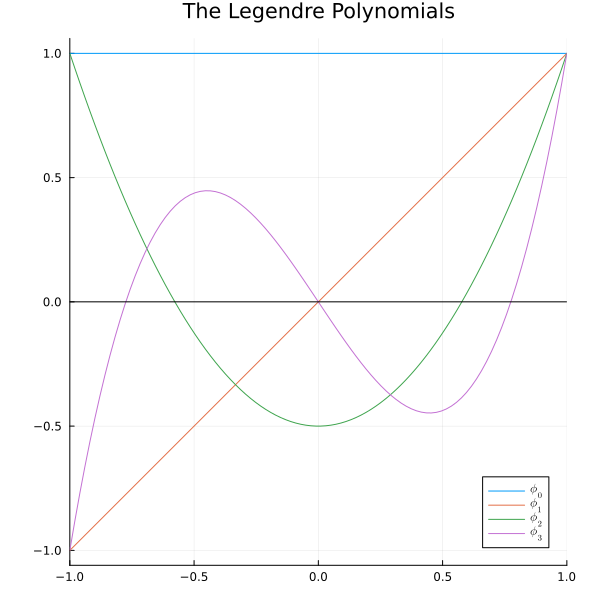

In [6]:
n = 3

xx = range(-1, 1, length=100)

ϕ0, ϕ1 = ones(length(xx)), xx
plot(legend=:bottomright, aspect_ratio=:equal, 
    xlims=(-1,1), size=(600,600),
    title="The Legendre Polynomials")
plot!(xx, ϕ0, label=L"\phi_0")
plot!(xx, ϕ1, label=L"\phi_1")

# Using the three-term recurrence relation to compute Legendre polynomials
ϕolder, ϕold = ϕ0, ϕ1
for k=1:n-1
    ϕ = ((2k+1)*xx.*ϕold - k*ϕolder)/(k+1)
    ϕolder, ϕold = ϕold, ϕ
    plot!(xx, ϕ, label=latexstring("\\phi_$(k+1)"))
end
hline!([0], c=:black, label=:none)

---

## Gauss points

Let $x_0, \ldots, x_n$ be the roots of the Legendre polynomial $\phi_{n+1}$; these points are known as the **Gauss points**.

Let $p_n$ be the polynomial that interpolates the points

$$(x_0, f(x_0)), \ldots, (x_n, f(x_n)).$$

We can write $p_n$ in **Lagrange form** as

$$p_n(x) = \sum_{i=0}^n f(x_i) L_i(x),$$

where the Lagrange polynomials are given by

$$L_i(x) = \prod_{\substack{j = 1 \\ j \neq i}}^n \frac{x - x_j}{x_i - x_j}, \quad i = 0,\ldots,n.$$

## Gaussian quadrature

We approximate the integral as

$$\int_{-1}^1 f(x)\,dx \approx \int_{-1}^1 p_n(x)\,dx = \sum_{i=0}^n c_i f(x_i),$$

where

$$c_i = \int_{-1}^1 L_i(x)\, dx, \quad i = 0,\ldots,n.$$

> ### Theorem: (Precision of Gaussian quadrature is $2n+1$)
> If $f(x)$ is any polynomial having degree at most $2n + 1$, then
>
> $$\int_{-1}^1 f(x)\, dx = \int_{-1}^1 p_n(x)\,dx,$$
>
> where $p_n$ is the polynomial that interpolates $f$ at the roots of the Legendre polynomial $\phi_{n+1}$ (i.e., at the **Gauss points** $x_0,\ldots,x_n$).

### Proof:

We follow the proof from the book _Numerical Analysis_ by Burden and Faires.

By the Polynomial Interpolation Error Theorem we have that for each $x \in [-1,1]$, there is a $\xi(x) \in (-1,1)$ such that

$$f(x) = p_n(x) + \frac{f^{(n+1)}(\xi(x))}{(n+1)!} \prod_{i=0}^n (x - x_i).$$

First we will suppose that $f(x)$ is a polynomial having degree at most $n$. Then $f^{(n+1)} \equiv 0$, so we have that $f(x) = p_n(x)$, for all $x \in [-1,1]$. Therefore,

$$\int_{-1}^1 f(x)\,dx = \int_{-1}^1 p_n(x)\,dx = \sum_{i=0}^n c_i f(x_i),$$

where

$$c_i = \int_{-1}^1 \prod_{\substack{j = 1 \\ j \neq i}}^n \frac{x - x_j}{x_i - x_j} dx, \quad i = 0,\ldots,n.$$

Now we suppose that $n+1 \leq \deg(f) \leq 2n + 1$. Dividing $f(x)$ by $\phi_{n+1}(x)$, we will obtain a polynomial **quotient** of $q(x)$ and a polynomial **remainder** of $r(x)$ such that

$$f(x) = q(x) \phi_{n+1}(x) + r(x)$$

and $\deg(r) < \deg(\phi_{n+1}) = n+1$; thus, $\deg(r) \leq n$.

In addition, we have

$$\deg(f) = \deg(q) + \deg(\phi_{n+1}),$$

so

$$n+1 \leq \deg(q) + \deg(\phi_{n+1}) \leq 2n + 1,$$

which implies that

$$ 0 \leq \deg(q) \leq n.$$

Thus, we have that

$$
\begin{split}
\int_{-1}^1 f(x)\,dx 
&= \int_{-1}^1 q(x) \phi_{n+1}(x)\, dx + \int_{-1}^1 r(x)\, dx \\
&= 0 + \int_{-1}^1 r(x)\, dx \\
&= \int_{-1}^1 r(x)\, dx. \\
\end{split}
$$

Since $\deg(r) \le n$ and

$$
\begin{split}
f(x_i) 
&= q(x_i) \phi_{n+1}(x_i) + r(x_i) \\
&= q(x_i) \cdot 0 + r(x_i) \\
&= r(x_i),
\end{split}
$$

for $i = 0,\ldots, n$, the first part of the proof then implies that 

$$\int_{-1}^1 r(x)\,dx = \sum_{i=0}^n c_i r(x_i) = \sum_{i=0}^n c_i f(x_i) = \int_{-1}^1 p_n(x)\,dx.$$

Thus, we have that

$$
\int_{-1}^1 f(x)\,dx = \int_{-1}^1 r(x)\, dx = \int_{-1}^1 p_n(x)\, dx,
$$

which completes the proof. $\blacksquare$

---

## Gauss quadrature

-   For $n = 0$, the only root of $\phi_1(x) = x$ is:

    $$x_0 = 0$$
    
    Then
    
    $$ \int_{-1}^1 f(x) \,dx \approx 2 f(0). $$
    
    Thus, we obtain the **midpoint rule** which has **precision 1**.
    

-   For $n = 1$, the roots of $\phi_2(x) = \frac{1}{2}(3x^2 - 1)$ are:

    $$x_0, x_1 = -\frac{1}{\sqrt{3}}, \frac{1}{\sqrt{3}}$$
    
    Then
    
    $$ \int_{-1}^1 f(x)\, dx \approx f\paren{-\frac{1}{\sqrt{3}}} + f\paren{\frac{1}{\sqrt{3}}}.$$
    
    This is a rule that has **precision 3**.

-   For $n = 2$, the roots of $\phi_3(x) = \frac{1}{2}(5x^3 - 3x)$ are:

    $$x_0, x_1, x_2 = -\sqrt{\frac{3}{5}}, 0, \sqrt{\frac{3}{5}}$$
    
    In this case, we have the **precision 5** rule:
    
    $$ \int_{-1}^{1} f(x)\, dx \approx \frac{1}{9} \paren{5f\paren{-\sqrt{\frac{3}{5}}} + 8f(0) + 5f\paren{\sqrt{\frac{3}{5}}} }.$$

- In general, we have the formula
    
    $$ \int_{-1}^1 f(x) \,dx = \sum_{i=0}^n c_i f(x_i) + \frac{2^{2n+3}[(n+1)!]^4}{(2n+3)![(2n+2)!]^2} f^{(2n+2)}(\xi), $$
    
     for some $\xi \in [-1,1]$, where
    
    $$ c_i = \frac{2(1 - x_i^2)}{\brack{(n+1)\phi_n(x_i)}^2}, \quad i=0,\ldots,n. $$

---

## Composite Gaussian quadrature

We will now approximate $\int_a^b f(x)\,dx$ by dividing the interval $[a,b]$ into $r$  subintervals:

$$[t_0,t_1], \quad [t_1,t_2], \quad \ldots, \quad [t_{r-1},t_r],$$

where $a = t_0 < t_1 < \cdots < t_r = b$.

In order to use Gaussian quadrature on interval $[t_{k-1},t_k]$, we need to make a change of variables:

$$ t = \frac{t_k - t_{k-1}}{2} (x + 1) + t_{k-1}, \quad -1 \leq x \leq 1. $$

Then,

$$
\begin{split}
\int_{t_{k-1}}^{t_k} f(t)\,dt 
&= \int_{-1}^1 f\paren{\frac{t_k - t_{k-1}}{2} (x + 1) + t_{k-1}} \frac{t_k - t_{k-1}}{2}\,dx \\
&\approx \sum_{i=0}^n c_i f\paren{\frac{t_k - t_{k-1}}{2} (x_i + 1) + t_{k-1}} \frac{t_k - t_{k-1}}{2},\\
\end{split}
$$

where $x_0,\ldots,x_n$ are the **Gauss points** and 

$$c_i = \int_{-1}^1 \prod_{\substack{j = 1 \\ j \neq i}}^n \frac{x - x_j}{x_i - x_j} dx = \frac{2(1 - x_i^2)}{\brack{(n+1)\phi_n(x_i)}^2}, \quad i = 0,\ldots,n.$$

We can simplify this formula by defining

$$
\begin{align}
t_{k,i} &= \frac{t_k - t_{k-1}}{2} (x_i + 1) + t_{k-1}, \\
\\
b_{k,i} &= c_i \frac{t_k - t_{k-1}}{2}, \\
\end{align}
$$

for $i = 0,\ldots,n$.

Then we have

$$\int_a^b f(x)\, dx \approx \sum_{k=1}^r \sum_{i=0}^n b_{k,i} f(t_{k,i}).$$

### Uniform mesh

If $[a,b]$ is divided into $r$ equal subintervals with $h = (b - a)/r$ and $t_k = a + kh$, for $k = 0, \ldots, r$, then we define

$$
t_{k,i} = \frac{h}{2} (x_i + 1) + t_{k-1}, \qquad b_i = c_i \frac{h}{2},
$$

and it can be shown that 

$$\int_a^b f(x)\, dx = \sum_{k=1}^r \sum_{i=0}^n b_i f(t_{k,i}) + \frac{(b - a)((n+1)!)^4}{(2n+3)!((2n+2)!)^2} f^{(2n+2)}(\xi) h^{2n+2},$$

for some $\xi \in [a,b]$.

Thus, we have an accuracy of $\mathcal{O}(h^{2n+2})$ and the number of function evaluations is $r(n+1)$.

---

## Example

Let's use **composite Gaussian quadrature** to approximate

$$\int_0^1 e^{-x^2} dx = \frac{\sqrt{\pi}}{2}\mathrm{erf}(1) = 0.746824132812427\ldots.$$

In [ ]:
import Polynomials

##################################################
function mylegendre(n, x)
    
    ϕk, ϕkp1 = 1, x
    for k=1:n-1
        ϕkp2 = (2k+1)//(k+1)*x*ϕkp1 - k//(k+1)*ϕk
        ϕk, ϕkp1 = ϕkp1, ϕkp2
    end
    
    if n==0
        1
    else
        ϕkp1
    end
    
end

##################################################
function gauss_points(n)

    x = Polynomials.Polynomial([0, 1])

    p = Polynomials.roots(mylegendre(n, x))

    sort(p)

end

##################################################

gauss_points(7)

In [ ]:
##################################################
function gaussquad(f, a, b, r, n)

    h = (b - a)/r
    tt = a:h:b
    
    # Get the roots of the (n+1)st Legendre polynomial
    xx = gauss_points(n+1)

    # Compute the matrix of remapped Gauss points
    T = Float64[h/2*(xi + 1) + tkm1 for tkm1 in tt[1:end-1], xi in xx]
    fT = f.(T)

    # Compute the quadrature weights
    cc = Float64[2*(1-xi^2)/((n+1)*mylegendre(n,xi))^2 for xi in xx]
    bb = cc*h/2

    # Compute the composite Gaussian quadrature
    sum(fT*bb)
end

In [ ]:
using SpecialFunctions, Printf

##################################################
f(x) = exp(-x^2)
a, b = 0, 1

rr = 1:8
nn = 0:6

vals = Float64[gaussquad(f, a, b, r, n) for r = rr, n = nn]

intval = √π/2*erf(1.0)
abserr = abs.(vals .- intval)

function printarray(data::Matrix{T}, rr, nn) where T
    m, n = length(rr), length(nn)
    @printf("%6s", "")
    for j=1:n
        @printf(" %4s%2d", "n =", nn[j])
    end
    println()
    for i=1:m
        @printf("%4s%2d", "r =", rr[i])
        for j=1:n
            if T <: Integer
                @printf(" %6d", data[i,j])
            else
                @printf(" %6.0e", data[i,j])
            end
        end
        println()
    end
end

printarray(abserr, rr, nn)

In [ ]:
nfevals = [r*(n+1) for r in rr, n in nn]
printarray(nfevals, rr, nn)

In [ ]:
plt = plot(title="Composite Gaussian quadrature error",
    xlabel="number of function evaluations",
    ylabel="absolute error",
    yscale=:log,
    size=(800,600)
)
for ii = 1:size(abserr, 2)
    plot!(nfevals[:,ii], abserr[:,ii], m=:circle, label="n = $(nn[ii])")
end
plt

---